# Sentiment Analysis using LSTM

Created by Sanjay Raghuwanshi, XAI part added by Marta Kłosok  
Link to original repo containing LSTM part *https://github.com/sanjay-raghu/sentiment-analysis-using-LSTM-keras*

**Created by Sanjay Raghuwanshi ** <br/>
[Github](https://github.com/sanjay-raghu) <br/>
[Linkedin](https://www.linkedin.com/in/sanjayiitg/) <br/>
**Sentiment Analysis:** the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

**Solving class imbalaned data**:
- upsampling 
- using class weighted loss function

Using LSTM to classify the movie reviews into positive and negative.


#### *Remarks*

To produce the results for DeepExplainer object you need to use Python 3.6 version and 1.14.0 Tensorflow version with latest SHAP package (shap==0.41.0). Rest of the package is listed in requirements.txt. 

In [25]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re


Reading data and keeping  only the necessary columns.

In [26]:
data = pd.read_csv('../data/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

Data preview

In [27]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [28]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
# removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


In [29]:
print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt','')
data.head()

4472
16986


,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbott_tx tedcruz on my first day i will ...,Positive
6,warriorwoman91 i liked her and was happy when...,Negative


In [30]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ..., 1308, 1394,  733],
       [   0,    0,    0, ...,  231,  713,   17],
       [   0,    0,    0, ...,  204,  366,  678],
       ...,
       [   0,    0,    0, ...,   71,   65,    3],
       [   0,    0,    0, ..., 1007, 1406,   74],
       [   0,    0,    0, ...,  194,    3,  712]], dtype=int32)

Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [31]:
X.shape

(10729, 28)

In [46]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 197       
Total params: 510,997
Trainable params: 510,997
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [47]:
Y = pd.get_dummies(data['sentiment']).values
target = Y[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, target,test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8583, 28) (8583,)
(2146, 28) (2146,)


Here we train the Network. We should run much more than 7 epoch, but I would have to wait forever for kaggle, so it is 7 for now.

In [48]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
8583/8583 [==============================] - 10s 1ms/sample - loss: 3.2210 - acc: 0.7899
Epoch 2/15
8583/8583 [==============================] - 10s 1ms/sample - loss: 3.2210 - acc: 0.7899
Epoch 3/15
8583/8583 [==============================] - 8s 943us/sample - loss: 3.2210 - acc: 0.7899
Epoch 4/15
8583/8583 [==============================] - 8s 980us/sample - loss: 3.2210 - acc: 0.7899
Epoch 5/15
8583/8583 [==============================] - 8s 987us/sample - loss: 3.2210 - acc: 0.7899
Epoch 6/15
8583/8583 [==============================] - 9s 996us/sample - loss: 3.2210 - acc: 0.7899
Epoch 7/15
8583/8583 [==============================] - 8s 967us/sample - loss: 3.2210 - acc: 0.7899
Epoch 8/15
8583/8583 [==============================] - 9s 1ms/sample - loss: 3.2210 - acc: 0.7899
Epoch 9/15
8583/8583 [==============================] - 9s 1ms/sample - loss: 3.2210 - acc: 0.7899
Epoch 10/15
8583/8583 [==============================] - 8s 980us/sample - loss: 3.2210 - acc: 0.

Extracting a validation set, and measuring score and accuracy.

In [49]:
Y_pred = model.predict(X_test, batch_size = batch_size)
Y_pred = [float(x) for x in Y_pred]

In [50]:
Y_pred

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [44]:
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred': Y_pred})

In [45]:
df_test

,true,pred
0,0,0.106161
1,0,0.995222
2,1,0.070109
3,1,0.998447
4,0,0.999319
...,...,...
2141,1,0.961874
2142,1,0.990983
2143,0,0.201286
2144,1,0.003703


In [47]:

# df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
# print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
# print(classification_report(df_test.true, df_test.pred))

Finally measuring the number of correct guesses.  It is clear that finding negative tweets (**class 0**) goes very well (**recall 0.92**) for the Network but deciding whether is positive (**class 1**) is not really (**recall 0.52**). My educated guess here is that the positive training set is dramatically smaller than the negative, hence the "bad" results for positive tweets.

# Explain the model with DeepExplainer


In [12]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model.predict, X_train[:100])
explainer = shap.DeepExplainer(model, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

In [13]:
shap_values[0].shape

(10, 28)

In [15]:
words_dict = tokenizer.word_index

In [16]:
num2word = {}
for w in words_dict.keys():
    num2word[words_dict[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), X_test[i]))) for i in range(10)])


In [17]:
x_test_words

array([['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
        'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'done', 'with',
        'foxnews', 'after', 'last', 'nights', 'gopdebate', 'megynkelly',
        'showed', 'her', 'true', 'but', 'realdonaldtrump', 'trump2016'],
       ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
        'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
        'sallykohn', 'megynkelly', 'megyn', 'you', 'are', 'now',
        'officially', 'on', 'the', 'hit', 'megynkelly', 'gopdebate'],
       ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
        'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
        'NONE', 'NONE', 'NONE', 'NONE', 'gopdebate', 'was', 'a', 'great',
        'performance', 'they', 'should', 'do'],
       ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
        'NONE', 'NONE', 'NONE', 'NONE', 'rwsurfergirl', 'after',
        'govchristie', 'hugg

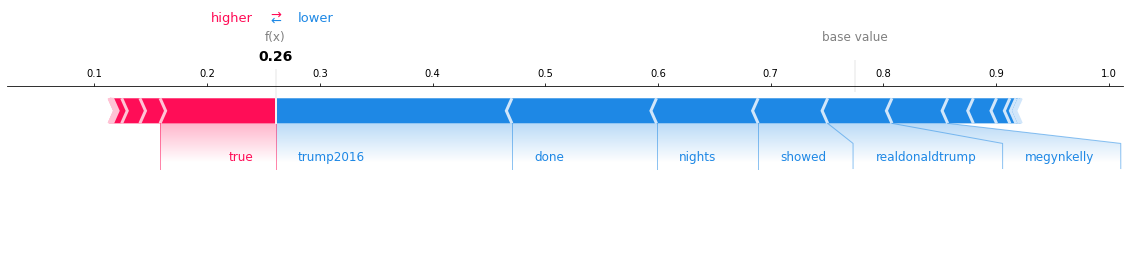

In [21]:
# shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0], matplotlib=True, show = False)



In [24]:
shap_values[0]

array([[ 0.00000000e+00,  0.00000000e+00,  3.47393235e-05,
         5.57527045e-05,  1.74195277e-04,  2.40982602e-04,
         4.68420716e-04,  1.73688715e-04,  2.24534707e-04,
         2.82819263e-04,  7.42632364e-04,  6.69301519e-04,
        -1.93914262e-03, -2.82333596e-03, -1.28262191e-01,
        -1.18404744e-02, -2.27369427e-02,  1.61711842e-02,
         1.78703490e-02, -9.01715756e-02, -5.35924801e-03,
        -4.94420241e-02, -6.16911464e-02,  8.11867740e-03,
         1.02433053e-01, -2.06189381e-02, -5.70111401e-02,
        -2.09701450e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.97943110e-06,
         2.95966211e-05,  2.70593315e-05,  9.85323848e-05,
         1.56079053e-04, -2.38111888e-05,  5.03878408e-05,
         1.06984903e-03,  1.12979740e-03,  1.12974512e-03,
         2.29482377e-03,  2.48923184e-03, -1.05917180e-04,
         2.36451153e-03,  3.89841008e-02, -7.91573095e-03,
         8.49785635e-03,  1.94949571e-02,  1.76660431e-02,
         1.32461099e-02,  5.74

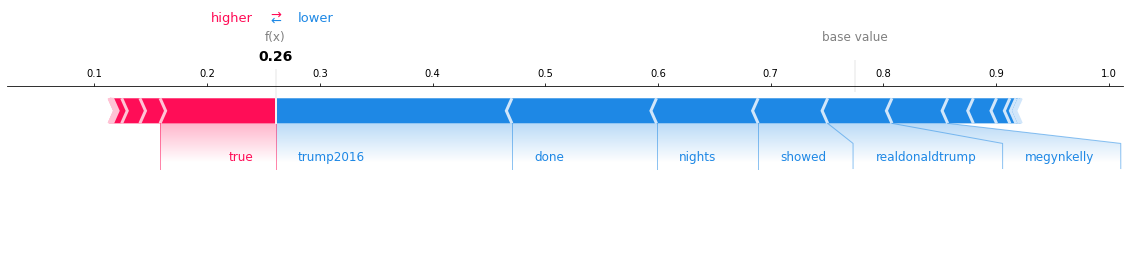

In [20]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0], matplotlib=True, show = False)

